## Traffic eChallan Data Analysis

Taking data from Database using MySQL Connection

In [170]:
import mysql.connector
import pandas as pd

In [171]:
# Replace these with your database credentials
host = 'your_hostname'
user = 'your_username'
password = 'your_password'
database = 'your_database'

# Create a connection to the database
connection = mysql.connector.connect(
    host=host,
    user=user,
    password=password,
    database=database
)


In [172]:
query = "SELECT * FROM rough_data"
cursor = connection.cursor()
cursor.execute(query)

# Fetch the data
data = cursor.fetchall()

# If you want to fetch column names as well
column_names = [desc[0] for desc in cursor.description]

df = pd.DataFrame(data, columns=column_names)

cursor.close()
connection.close()

In [173]:
df.head()

,id,rc_number,latitude,longitude,camera_location_id,circle_id,address,district,state,offences,fine,status,created_at,survey_date,speed_limit,actual_speed,vh_class
0,2506583,UP51AP3312,26.6638,81.2521,10.11.23.81,41.0,VSDS 23 900 RHS,Bara Banki,UP,Overspeeding,2000,Pending,36:00.0,35:40.0,100,109,Car
1,2506584,UP32HA7431,26.6638,81.2521,10.11.23.81,41.0,VSDS 23 900 RHS,Bara Banki,UP,Overspeeding,2000,Pending,38:00.0,36:10.0,100,111,Car
2,2506585,UP50AP2987,26.6638,81.2521,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,46:00.0,45:32.0,100,106,Car
3,2506586,DL2CAM4667,26.6638,81.2521,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,04:00.0,01:56.0,100,109,Car
4,2506587,UP32LX2004,26.6638,81.2521,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,08:00.0,06:35.0,100,133,Car


In [174]:
data = df.copy()

In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import pointbiserialr

# Load the dataset (can be removed if data is to be taken from SQL server as shown above)
# I have used data from CSV below to show the data processing steps as the data imported above from my localhost MySQL server is already processed.
data = pd.read_csv("E:\\VSCode_workshop\\python_workshop\\nic_eChallan\\ITMS_Staging\\traffic_violations.csv")

# Display basic information about the dataset
print(data.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 988 entries, 0 to 987
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  988 non-null    int64  
 1   rc_number           988 non-null    object 
 2   latitude            985 non-null    float64
 3   longitude           985 non-null    float64
 4   camera_location_id  988 non-null    object 
 5   circle_id           978 non-null    float64
 6   address             985 non-null    object 
 7   district            988 non-null    object 
 8   state               988 non-null    object 
 9   offences            988 non-null    object 
 10  fine                988 non-null    int64  
 11  status              988 non-null    object 
 12  created_at          988 non-null    object 
 13  survey_date         988 non-null    object 
 14  speed_limit         988 non-null    int64  
 15  actual_speed        988 non-null    int64  
 16  vh_class

In [176]:
data.head()

,id,rc_number,latitude,longitude,camera_location_id,circle_id,address,district,state,offences,fine,status,created_at,survey_date,speed_limit,actual_speed,vh_class
0,2507582,TN02AM2048,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,6343,0,Pending,20:00.0,04:31.0,80,71,NaN
1,2507581,KA04MB7226,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,6343,2000,Pending,20:00.0,04:29.0,80,86,NaN
2,2507580,TN54AM0504,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,6343,0,Pending,20:00.0,04:11.0,80,60,NaN
3,2507579,TN19AH7403,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,6343,0,Pending,20:00.0,04:10.0,80,61,NaN
4,2507578,TN39CU5115,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,6343,0,Pending,20:00.0,03:59.0,80,62,NaN


In [177]:
value_mapping = {
    '2392': 'Overspeeding',
    '8589': 'Red Light Violation',
    '6343': 'No Helmet',
    '10077': 'Triple Riding',
    '10069': 'Stop Line',
    '11645': 'Improper Parking'
}

# Replace values in the 'offence_type' column using the mapping
data['offences'] = data['offences'].replace(value_mapping)

# Drop rows where 'offences' is not in the predefined codes (values that were not replaced)
data = data[data['offences'].isin(value_mapping.values())]

# Replace NaN values in 'vh_class' column with 'mc'
data['vh_class'].fillna('MCWG/MCWNG', inplace=True)

print(data['offences'].unique())
print(data['offences'].value_counts())

print(data['vh_class'].unique())
print(data['vh_class'].value_counts())

print(data['vh_class'].count())

['No Helmet' 'Overspeeding' 'Improper Parking' 'Red Light Violation'
 'Stop Line' 'Triple Riding']
Overspeeding           774
Red Light Violation    155
No Helmet               27
Triple Riding           13
Stop Line                4
Improper Parking         3
Name: offences, dtype: int64
['MCWG/MCWNG' 'Car' 'LCV' 'Truck' 'LMV' 'Bus' 'HMV' 'Oversized']
Car           519
LMV           150
Truck         127
LCV            77
Bus            50
MCWG/MCWNG     47
HMV             5
Oversized       1
Name: vh_class, dtype: int64
976


In [178]:
import math

# Convert the time columns to the correct format
def convert_time(row):
    h, m = row['survey_date'].split(':')
    scaled_hours = math.ceil(float(h) / 2.5)
    hours = scaled_hours if scaled_hours != 24 else 0
    minutes = int((float(m))) 
    return f'{hours:02d}:{minutes:02d}'

data['survey_time'] = data.apply(convert_time, axis=1)

print(data['survey_time'])

0      02:31
1      02:29
2      02:11
3      02:10
4      02:59
       ...  
983    03:35
984    01:56
985    18:32
986    15:10
987    14:40
Name: survey_time, Length: 976, dtype: object


In [179]:
data

,id,rc_number,latitude,longitude,camera_location_id,circle_id,address,district,state,offences,fine,status,created_at,survey_date,speed_limit,actual_speed,vh_class,survey_time
0,2507582,TN02AM2048,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,0,Pending,20:00.0,04:31.0,80,71,MCWG/MCWNG,02:31
1,2507581,KA04MB7226,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,2000,Pending,20:00.0,04:29.0,80,86,MCWG/MCWNG,02:29
2,2507580,TN54AM0504,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,0,Pending,20:00.0,04:11.0,80,60,MCWG/MCWNG,02:11
3,2507579,TN19AH7403,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,0,Pending,20:00.0,04:10.0,80,61,MCWG/MCWNG,02:10
4,2507578,TN39CU5115,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,0,Pending,20:00.0,03:59.0,80,62,MCWG/MCWNG,02:59
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2506587,UP32LX2004,26.663826,81.252123,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,08:00.0,06:35.0,100,133,Car,03:35
984,2506586,DL2CAM4667,26.663826,81.252123,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,04:00.0,01:56.0,100,109,Car,01:56
985,2506585,UP50AP2987,26.663826,81.252123,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,46:00.0,45:32.0,100,106,Car,18:32
986,2506584,UP32HA7431,26.663820,81.252130,10.11.23.81,41.0,VSDS 23 900 RHS,Bara Banki,UP,Overspeeding,2000,Pending,38:00.0,36:10.0,100,111,Car,15:10


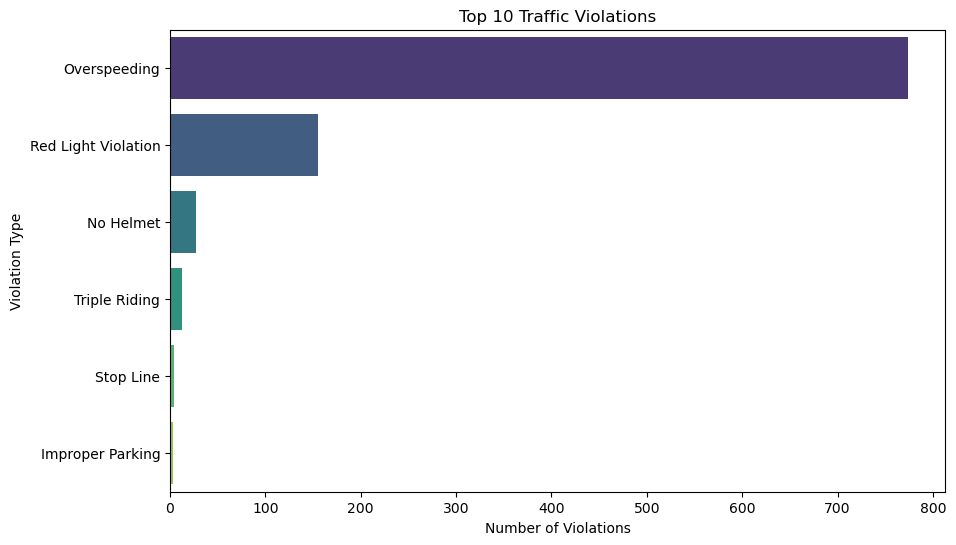

In [180]:
# Create a bar plot of the top N violations
top_n = 10
top_violations = data['offences'].value_counts().head(top_n)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_violations.values, y=top_violations.index, palette="viridis")
plt.title(f"Top {top_n} Traffic Violations")
plt.xlabel("Number of Violations")
plt.ylabel("Violation Type")
plt.show()

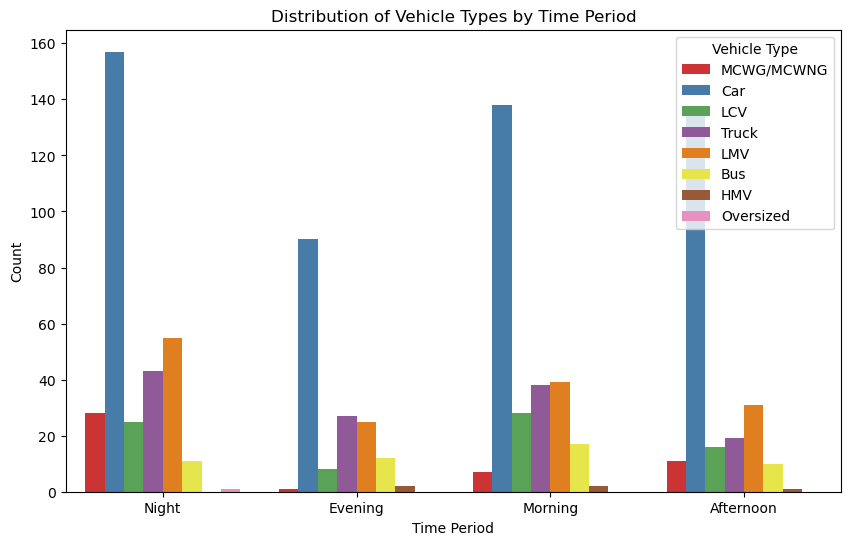

In [181]:
# Convert survey_time to datetime
data['survey_time'] = pd.to_datetime(data['survey_time'], format="%H:%M")

# Categorize time into bins (morning, afternoon, evening, night)
def categorize_time_period(time):
    if 5 <= time.hour < 12:
        return "Morning"
    elif 12 <= time.hour < 17:
        return "Afternoon"
    elif 17 <= time.hour < 21:
        return "Evening"
    else:
        return "Night"

data['time_period'] = data['survey_time'].apply(categorize_time_period)

# Plotting the distribution of vehicle types by time period
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='time_period', hue='vh_class', palette='Set1')
plt.title("Distribution of Vehicle Types by Time Period")
plt.xlabel("Time Period")
plt.ylabel("Count")
plt.legend(title='Vehicle Type')
plt.show()

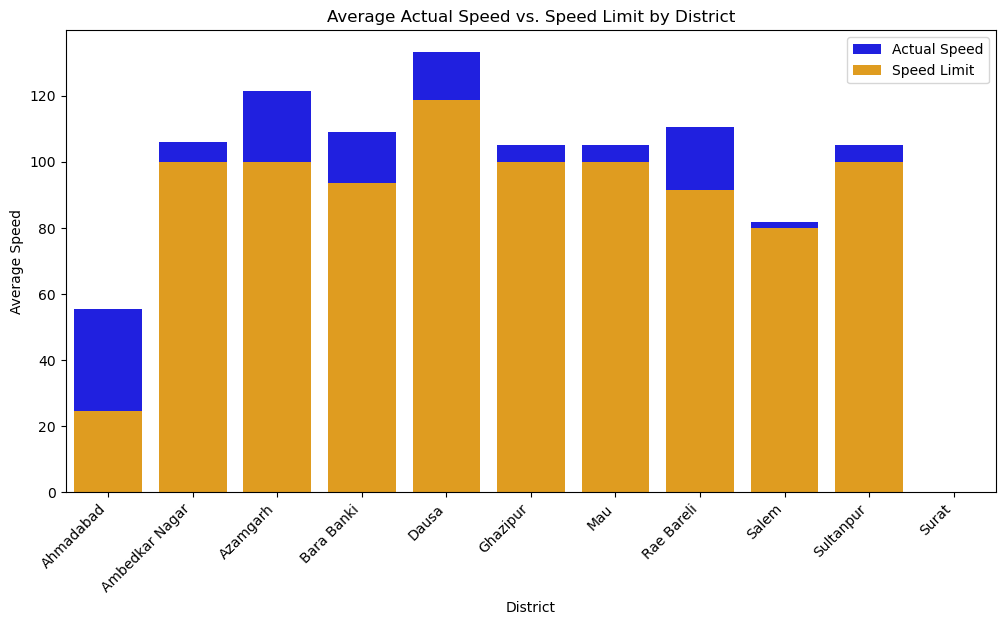

In [182]:
# Calculate the average actual speed and speed limit for each district
average_speeds = data.groupby('district')[['actual_speed', 'speed_limit']].mean().reset_index()

# Plotting the grouped bar plot
plt.figure(figsize=(12, 6))
sns.barplot(data=average_speeds, x='district', y='actual_speed', color='blue', label='Actual Speed')
sns.barplot(data=average_speeds, x='district', y='speed_limit', color='orange', label='Speed Limit')
plt.title("Average Actual Speed vs. Speed Limit by District")
plt.xlabel("District")
plt.ylabel("Average Speed")
plt.xticks(rotation=45, ha='right')
plt.legend()
plt.show()


Year wise change in Offence Counts for a Given District

In [183]:
# Took random years for demonstration as values are missing in the staging dataset

# Generate random years between 2010 and 2023 (inclusive)
random_years = np.random.randint(2010, 2024, size=len(data))

# Update the 'year' column with the random years
data['year'] = random_years

offences  Stop Line  Triple Riding
year                              
2010              0              1
2011              0              1
2013              1              2
2014              0              1
2015              1              1
2017              0              2
2018              0              3
2020              1              0
2021              0              2
2023              1              0


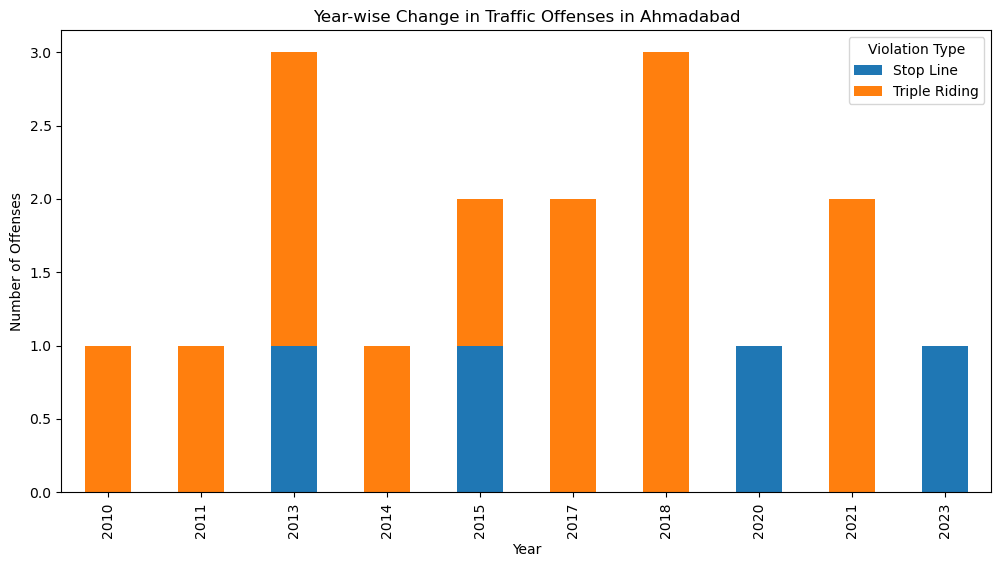

In [184]:
# Use this to get the year from survey_date column for the real data
# data['year'] = pd.to_datetime(data['survey_time']).dt.year

# Filter the data for the specific district of interest
district_of_interest = 'Ahmadabad'
district_data = data[data['district'] == district_of_interest]

# Count the occurrences of each violation type for each year
violation_counts = district_data.groupby(['year', 'offences']).size().unstack(fill_value=0)

print(violation_counts)
# Create a stacked bar plot
violation_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title(f'Year-wise Change in Traffic Offenses in {district_of_interest}')
plt.xlabel('Year')
plt.ylabel('Number of Offenses')
plt.legend(title='Violation Type', loc='upper right')
plt.show()


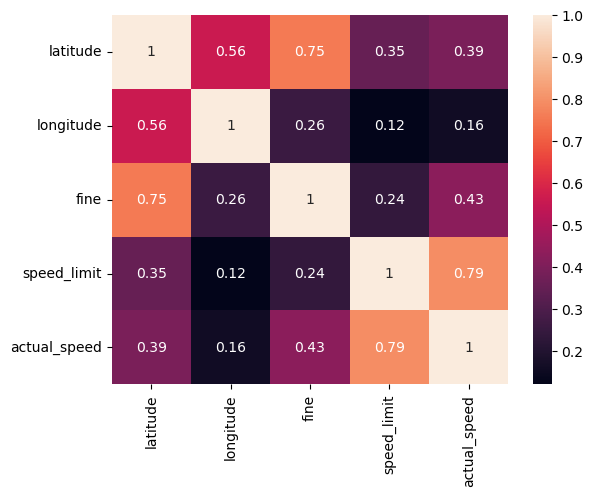

In [185]:
df_heat = data[['latitude', 'longitude', 'fine', 'speed_limit', 'actual_speed']]
sns.heatmap(df_heat.corr(),annot =True)
plt.show()

##### Heatmaps calculate the Pearson correlation coefficient, which is suitable for measuring linear relationships between continuous variables. However, it's not appropriate for visualizing or calculating the correlation between categorical variables.

##### Categorical variables don't have a linear relationship, and Pearson's correlation coefficient is not designed to capture associations between categorical data. Using this method on categorical columns will not provide meaningful results, and the heatmap may not accurately represent the relationships between those variables.

In [186]:
# Perform Chi-square test between 'Location' and 'Offence'
observed = pd.crosstab(data['offences'], data['address'])
chi2, p, dof, expected = chi2_contingency(observed)

print("Chi-square test results between 'Offences' and 'Location':")
print(f"Chi-square statistic: {'%.2f' % chi2}")
print(f"P-value: {'%.4f' % p}")

Chi-square test results between 'Offences' and 'Location':
Chi-square statistic: 4880.00
P-value: 0.0000


The chi-square test results indicate a statistically significant relationship between the 'Offences' and 'Location' columns in the dataset. The chi-square statistic value of 4880.0 and a very low p-value suggests that there is a significant association between these two categorical variables.

This result suggests that the distribution of offenses is not the same across different locations. In other words, the type of offense committed seems to be influenced by the location where the violation occurred.

In [187]:
# Perform point-biserial correlation test between 'actual_speed' and 'Fine'
point_biserial_corr = pointbiserialr(data['actual_speed'], data['fine'])
print("Point-biserial correlation between 'actual_speed' and 'Fine':")
print(f"Correlation coefficient: {point_biserial_corr.correlation}")
print(f"P-value: {point_biserial_corr.pvalue}")

Point-biserial correlation between 'actual_speed' and 'Fine':
Correlation coefficient: 0.4280411119450429
P-value: 9.321635491660903e-45


The point-biserial correlation coefficient of approximately 0.428 indicates a moderate positive relationship between 'actual_speed' and 'Fine', and the very low p-value suggests that this relationship is highly statistically significant. Therefore, you can infer that there is a meaningful and statistically significant connection between the actual speed of the driver (represented by 'actual_speed') and the fines associated with it ('Fine').

In [188]:
df = data.copy()

In [189]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = df.select_dtypes(include=['object']).columns

label_encoder = LabelEncoder()

for col in categorical_columns:
    df[col] = label_encoder.fit_transform(df[col])
df

,id,rc_number,latitude,longitude,camera_location_id,circle_id,address,district,state,offences,fine,status,created_at,survey_date,speed_limit,actual_speed,vh_class,survey_time,time_period,year
0,2507582,325,11.600891,78.090323,17,72.0,3,8,2,1,0,1,12,63,80,71,5,1900-01-01 02:31:00,3,2014
1,2507581,191,11.600891,78.090323,17,72.0,3,8,2,1,2000,1,12,62,80,86,5,1900-01-01 02:29:00,3,2016
2,2507580,336,11.600891,78.090323,17,72.0,3,8,2,1,0,1,12,59,80,60,5,1900-01-01 02:11:00,3,2017
3,2507579,327,11.600891,78.090323,17,72.0,3,8,2,1,0,1,12,58,80,61,5,1900-01-01 02:10:00,3,2021
4,2507578,333,11.600891,78.090323,17,72.0,3,8,2,1,0,1,12,53,80,62,5,1900-01-01 02:59:00,3,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2506587,503,26.663826,81.252123,0,41.0,7,3,3,2,2000,1,4,94,100,133,1,1900-01-01 03:35:00,3,2012
984,2506586,65,26.663826,81.252123,0,41.0,7,3,3,2,2000,1,2,27,100,109,1,1900-01-01 01:56:00,3,2017
985,2506585,677,26.663826,81.252123,0,41.0,7,3,3,2,2000,1,25,668,100,106,1,1900-01-01 18:32:00,1,2017
986,2506584,443,26.663820,81.252130,2,41.0,8,3,3,2,2000,1,21,511,100,111,1,1900-01-01 15:10:00,0,2023


In [190]:
import scipy.stats as stats

# Create a function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# Calculate Cramer's V for the categorical columns
cramer_v = cramers_v(df['offences'], df['address'])

# Cramer's V typically ranges from 0 (no association) to 1 (perfect association), and a value close to 1 indicates a high degree of association.
print("Cramer's V correlation between Offence Class and Address:", cramer_v)

Cramer's V correlation between Offence Class and Address: 0.9937951831133925


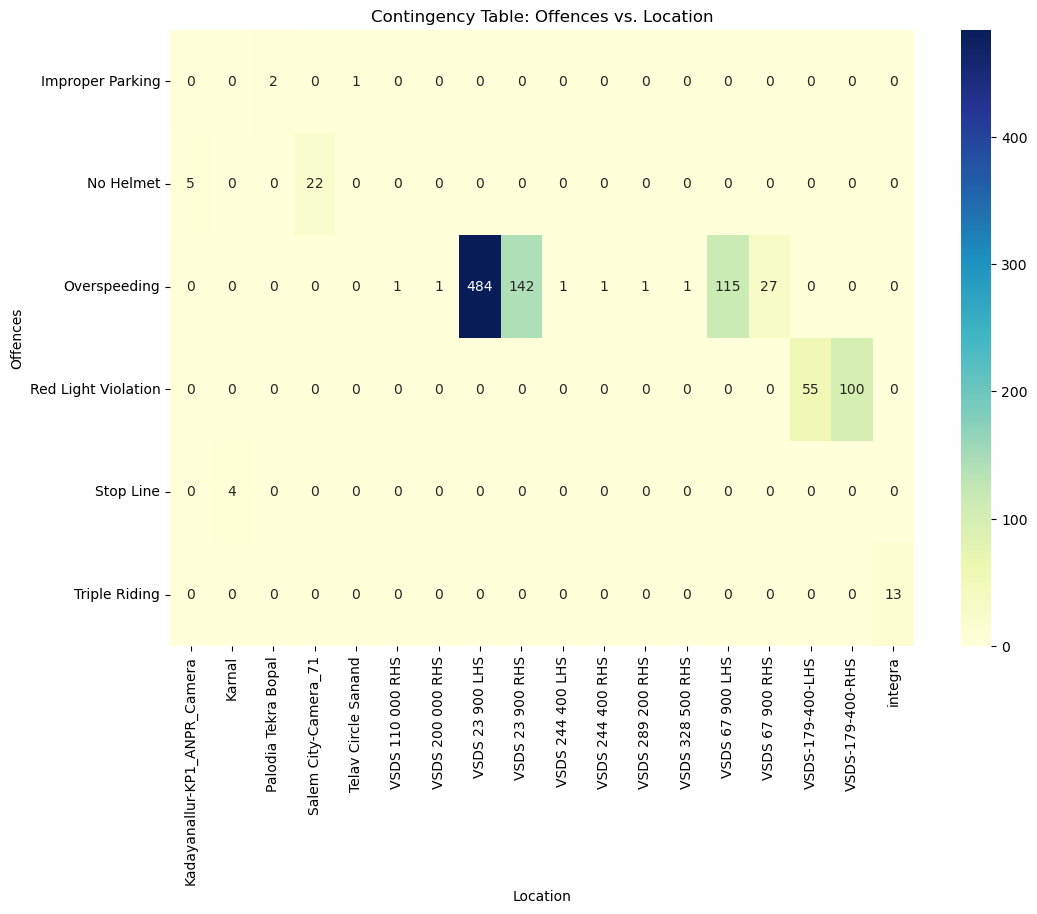

In [191]:
# Create a contingency table between 'Offences' and 'Location'
contingency_table = pd.crosstab(data['offences'], data['address'])

# Plot a heatmap of the contingency table
plt.figure(figsize=(12, 8))
sns.heatmap(contingency_table, cmap="YlGnBu", annot=True, fmt="d")
plt.title("Contingency Table: Offences vs. Location")
plt.xlabel("Location")
plt.ylabel("Offences")
plt.show()


In [192]:
df = data.copy()
df

,id,rc_number,latitude,longitude,camera_location_id,circle_id,address,district,state,offences,fine,status,created_at,survey_date,speed_limit,actual_speed,vh_class,survey_time,time_period,year
0,2507582,TN02AM2048,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,0,Pending,20:00.0,04:31.0,80,71,MCWG/MCWNG,1900-01-01 02:31:00,Night,2014
1,2507581,KA04MB7226,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,2000,Pending,20:00.0,04:29.0,80,86,MCWG/MCWNG,1900-01-01 02:29:00,Night,2016
2,2507580,TN54AM0504,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,0,Pending,20:00.0,04:11.0,80,60,MCWG/MCWNG,1900-01-01 02:11:00,Night,2017
3,2507579,TN19AH7403,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,0,Pending,20:00.0,04:10.0,80,61,MCWG/MCWNG,1900-01-01 02:10:00,Night,2021
4,2507578,TN39CU5115,11.600891,78.090323,CM27V142210001180,72.0,Salem City-Camera_71,Salem,TN,No Helmet,0,Pending,20:00.0,03:59.0,80,62,MCWG/MCWNG,1900-01-01 02:59:00,Night,2015
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
983,2506587,UP32LX2004,26.663826,81.252123,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,08:00.0,06:35.0,100,133,Car,1900-01-01 03:35:00,Night,2012
984,2506586,DL2CAM4667,26.663826,81.252123,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,04:00.0,01:56.0,100,109,Car,1900-01-01 01:56:00,Night,2017
985,2506585,UP50AP2987,26.663826,81.252123,10.11.23.62,41.0,VSDS 23 900 LHS,Bara Banki,UP,Overspeeding,2000,Pending,46:00.0,45:32.0,100,106,Car,1900-01-01 18:32:00,Evening,2017
986,2506584,UP32HA7431,26.663820,81.252130,10.11.23.81,41.0,VSDS 23 900 RHS,Bara Banki,UP,Overspeeding,2000,Pending,38:00.0,36:10.0,100,111,Car,1900-01-01 15:10:00,Afternoon,2023


Prediction of Offence based on Location and Vehicle Class

In [193]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [194]:
# Separate features and target variable
X = data[['address', 'district', 'state', 'vh_class', 'time_period', 'speed_limit' , 'actual_speed']]
y = data['offences'] 

# Label Encoding for target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# One-Hot Encoding for features
encoder = OneHotEncoder(drop='first', sparse_output=False)
X_encoded = encoder.fit_transform(X)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_encoded, test_size=0.3, random_state=42)

In [195]:
# Model Selection and Training
models = {
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=1000),
    'Support Vector Machine': SVC(),
    'Neural Network': MLPClassifier(max_iter=1000),
}

best_model = None
best_accuracy = 0

for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} - Accuracy: {accuracy * 100:.2f}')

Random Forest - Accuracy: 100.00
XGBoost - Accuracy: 100.00
Logistic Regression - Accuracy: 99.66
Support Vector Machine - Accuracy: 99.32
Neural Network - Accuracy: 100.00


Handling Class Imbalance by Applying SMOTE

In [196]:
# Apply SMOTE to handle class imbalance
smote = SMOTE(k_neighbors=2)
X_resampled, y_resampled = smote.fit_resample(X_encoded, y_encoded)

for model_name, model in models.items():
    model.fit(X_resampled, y_resampled)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'{model_name} - Accuracy: {accuracy * 100:.2f}')

Random Forest - Accuracy: 100.00
XGBoost - Accuracy: 100.00
Logistic Regression - Accuracy: 100.00
Support Vector Machine - Accuracy: 100.00
Neural Network - Accuracy: 100.00


Removing Overfitting Through Cross Validation

In [197]:
for model_name, model in models.items():
    # Using cross_val_score for cross-validation
    scores = cross_val_score(model, X_encoded, y_encoded, cv=3, scoring='accuracy')
    avg_accuracy = scores.mean()
    print(f'{model_name} - Average Accuracy: {avg_accuracy * 100:.2f}')
    
    if avg_accuracy > best_accuracy:
        best_accuracy = avg_accuracy
        best_model = model_name

print(f'Best Performing Model: {best_model} with Accuracy: {best_accuracy * 100:.2f}')

Random Forest - Average Accuracy: 99.79
XGBoost - Average Accuracy: 99.28
Logistic Regression - Average Accuracy: 99.79
Support Vector Machine - Average Accuracy: 99.79
Neural Network - Average Accuracy: 99.79
Best Performing Model: Random Forest with Accuracy: 99.79


In [199]:
user_input = []

# Collect input from the user for each remaining feature
for feature_name in X.columns:
    user_value = input(f'Enter value for {feature_name}: ')
    user_input.append(user_value)

# Convert user input to a DataFrame with appropriate feature names
user_input_df = pd.DataFrame([user_input], columns=X.columns)

user_input_df['speed_limit'] = pd.to_numeric(user_input_df['speed_limit'], errors='coerce')
user_input_df['actual_speed'] = pd.to_numeric(user_input_df['actual_speed'], errors='coerce')

user_input_df['speed_limit'] = user_input_df['speed_limit'].fillna(0).astype(int)
user_input_df['actual_speed'] = user_input_df['actual_speed'].fillna(0).astype(int)

# Encode user input
user_input_encoded = encoder.transform(user_input_df)

# Make prediction using the best performing model
best_model_instance = models[best_model]
predicted_class = best_model_instance.predict(user_input_encoded)

# Decode the predicted class back to the original label
predicted_offence = label_encoder.inverse_transform(predicted_class)[0]

print(f'Most Likely Offence: {predicted_offence}')

Most Likely Offence: Overspeeding


In [200]:
import folium
from folium.plugins import HeatMap

# Create a base map
m = folium.Map(location=[21.1458, 79.0882], zoom_start=5, max_bounds=True, max_lat=34.5)

# Create a HeatMap layer
heat_data = [[row['latitude'], row['longitude']] for index, row in data.iterrows()]
HeatMap(heat_data).add_to(m)

m